In [1]:
#add project directory to python path
import sys
sys.path.append("..")
#import standard packages
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline
from default import PROJECT_DIRECTORY, DATA_DIRECTORY

In [32]:
from astropy.io import fits
from astropy.table import Table

filepath = DATA_DIRECTORY
filename = 'hlist_0.76660.list.all.Vpeakcut160.0.corevel.reorg.fits'
hdulist = fits.open(filepath + filename)

halo_table = Table(np.array(hdulist[1].data))
print(halo_table.dtype.names)

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.307115) #MDR1 cosmology

('id', 'x', 'y', 'z', 'v5%_x', 'v5%_y', 'v5%_z', 'v10%_x', 'v10%_y', 'v10%_z', 'v15%_x', 'v15%_y', 'v15%_z', 'v20%_x', 'v20%_y', 'v20%_z', 'v25%_x', 'v25%_y', 'v25%_z', 'v33%_x', 'v33%_y', 'v33%_z', 'v50%_x', 'v50%_y', 'v50%_z', 'v100%_x', 'v100%_y', 'v100%_z')


In [34]:
filepath = DATA_DIRECTORY
filename = 'MDPL2_ROCKSTAR_Haloes_0.7666_mvir_cut.csv'
halo_table_sup = Table.read(filepath + filename, format='ascii.csv')
print(halo_table_sup.dtype.names)

('row_id', 'rockstarId', 'pId', 'upId', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Mvir', 'Vmax')


In [35]:
from halotools.utils import crossmatch

inds1, inds2 = crossmatch(halo_table_sup['rockstarId'], halo_table['id'])

halo_table['mass'] = 1.0
halo_table['mass'][inds2] = halo_table_sup['Mvir'][inds1]

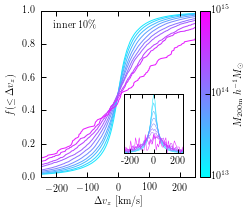

In [43]:
core_velocity_key = 'v10%_z'
bluk_velocity_key = 'v100%_z'

dv = halo_table[core_velocity_key]-halo_table[bluk_velocity_key]

#define halo mass bins
mass_bins = np.arange(13,15.2,0.2)
mass_bin_centers = (mass_bins[:-1]+mass_bins[1:])/2.0
mass_bins = 10**mass_bins
mass_bin_centers = 10**mass_bin_centers 

#bin haloes by mass
inds = np.digitize(halo_table['mass'], bins=mass_bins)

#run through halo mass bins and calculate distribution of v_bulk-v_core
from matplotlib import cm 
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(3.3,3.3))
fig.subplots_adjust(hspace=0, wspace=0, left=0.15, right=0.8, bottom=0.2, top=0.9)
for i in range(1,len(mass_bins)):
    
    mask = (inds==i)

    dv_sub = dv[mask]
    
    #calculate cumulative distribution
    sorted_dv_sub = np.sort(dv_sub)
    N = len(dv_sub)
    cum_counts = np.arange(0,N,1)/N
    
    color = cm.cool(1.0*i/len(mass_bins))
    ax.plot(sorted_dv_sub, cum_counts, color=color)
ax.set_xlabel(r'$\Delta v_z ~ [{\rm km/s}]$')
ax.set_ylabel(r'$f(\leq \Delta v_z)$')
ax.set_xlim([-250,250])
ax.set_ylim([0,1])
ax.text(-210,0.9,r'${\rm inner}~ 10\%$')

#colorbar
import matplotlib.colors as mcolors
dum = np.zeros(len(halo_table))-1
p = ax.scatter(dum, dum, c=(halo_table['mass']),
               vmin=np.min((mass_bins)),
               vmax=np.max((mass_bins)),
               lw=0, s=2,cmap='cool', rasterized=True,
               norm=mcolors.LogNorm())
cbar_ax = fig.add_axes([0.82, 0.2, 0.04, 0.7]) #xmin, ymin, +dx, +dy
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.set_label(r'$M_{200\rm m}~h^{-1}M_{\odot}$')
cbar.ax.yaxis.set_tick_params(pad=1)

ax_insert = fig.add_axes([0.5, 0.3, 0.25, 0.25])
ax_insert.get_yaxis().set_visible(False)
ax_insert.set_xlim([-250,250])
ax_insert.set_xticks([-200,-100,0,100,200])
ax_insert.set_xticklabels(['-200','','0','','200'])
ax_insert.tick_params(length=4)
ax_insert.xaxis.set_tick_params(pad=3)
dv_bins = np.linspace(-250,250,50)
dv_bin_centers = (dv_bins[:-1]+dv_bins[1:])/2.0
for i in range(1,len(mass_bins)):
    
    mask = (inds==i)

    dv_sub = dv[mask]
    
    counts = np.histogram(dv_sub, dv_bins)[0]
    counts = 1.0*counts/np.sum(mask)
    
    color = cm.cool(1.0*i/len(mass_bins))
    ax_insert.plot(dv_bin_centers, counts, color=color, lw=0.5) 

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'dv_core_dist'
fig.savefig(filepath + filename + '.pdf', dpi=300)

In [36]:
"""
normalize by the virial velocity
"""

def virial_velocity(mass, cosmo, redshift=0.0):
    """
    virial velocity
    """
    
    v_vir = 159.43 * (mass/10**12.0)**(1.0/3.0)
    
    return v_vir

#use 1-component of velocity
v_norm = np.sqrt((virial_velocity(halo_table['mass'], cosmo)**2.0/3.0))

1.58489319246e+13 0.364658350333
2.51188643151e+13 0.331474370681
3.98107170553e+13 0.302235214574
6.3095734448e+13 0.276144542072
1e+14 0.258328015242
1.58489319246e+14 0.247386227808
2.51188643151e+14 0.230468568991
3.98107170553e+14 0.223480113107
6.3095734448e+14 0.2080532845
1e+15 0.246149087835


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


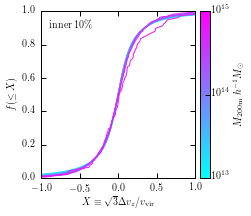

In [44]:
from scipy.stats import laplace

core_velocity_key = 'v10%_z'
bluk_velocity_key = 'v100%_z'

dv_norm = (halo_table[core_velocity_key]-halo_table[bluk_velocity_key])/v_norm

#define halo mass bins
mass_bins = np.arange(13,15.2,0.2)
mass_bins = 10**mass_bins

#bin haloes by mass
inds = np.digitize(halo_table['mass'], bins=mass_bins)

#run through halo mass bins and calculate distribution of v_bulk-v_core
from matplotlib import cm 
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(3.3,3.3))
fig.subplots_adjust(hspace=0, wspace=0, left=0.15, right=0.8, bottom=0.2, top=0.9)
x_sample = np.linspace(-1,1,50)
for i in range(1,len(mass_bins)):
    
    mask = (inds==i)

    dv_norm_sub = dv_norm[mask]
    scale = np.std(dv_norm_sub)/np.sqrt(2)
    print(mass_bins[i], scale)
    
    #calculate cumulative distribution
    sorted_dv_norm_sub = np.sort(dv_norm_sub)
    N = len(dv_norm_sub)
    cum_counts = np.arange(0,N,1)/N
    
    color = cm.cool(1.0*i/len(mass_bins))
    ax.plot(sorted_dv_norm_sub, cum_counts, color=color)
    #ax.plot(x_sample , laplace.cdf(x_sample, loc=0.0, scale=scale),  'o', color='black', ms=2, mec='none')
ax.set_xlabel(r'$X \equiv \sqrt{3} \Delta v_z/v_{\rm vir}$')
ax.set_ylabel(r'$f(\leq X)$')
ax.text(-0.9,0.9,r'${\rm inner}~ 10\%$')
ax.set_xlim([-1,1])
ax.set_ylim([0,1])

#colorbar
import matplotlib.colors as mcolors
dum = np.zeros(len(halo_table))-1
p = ax.scatter(dum, dum, c=(halo_table['mass']+0.1),
               vmin=np.min((mass_bins)),
               vmax=np.max((mass_bins)),
               lw=0, s=2,cmap='cool', rasterized=True,
               norm=mcolors.LogNorm())
cbar_ax = fig.add_axes([0.82, 0.2, 0.04, 0.7]) #xmin, ymin, +dx, +dy
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.set_label(r'$M_{200\rm m}~h^{-1}M_{\odot}$')
cbar.ax.yaxis.set_tick_params(pad=1)

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'dv_core_dist_norm'
fig.savefig(filepath + filename + '.pdf', dpi=300)